# 변이형 오토인코더 
- 임베딩벡터를 하나의 지점대신 발견가능성이높은 지역에 할당하는 느슨한 접근법 사용
- AE는 각이미지를 잠재공간의 한포인트에 맵핑(할당)한다.
- VAE는 잠재공간의 포인트 주변의 다변량정규분포(multivariate normal distribution)에 매핑된다
- 인코더는 각 입력을 평균벡터와 분산벡터에 매핑하면된다, 분산값은 분산의 로그에 매핑한다
- 입력이미지를 잠재공간의 다변량정규분포를 정의하는 다음 2개의 벡터로인코딩
z_mean, z_log_var
- 이런 값들로 정의된 분포에서 포인트 z를 샘플링한다\
 z=z_mean + z_sigma*epsilon
- z_sigma = exp(z_log_var*0.5), epsilon ~ N(0,I)
$$\sigma = exp(log(\sigma)) = exp(\frac{2log(\sigma)}{2}) = exp(\frac{log(\sigma^2)}{2}) $$
- 구조는 AE와 동일하다
- 인코더에서 손실함수를 바꾼다


In [3]:
# VAE구현하기

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm


(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

def preprocess(imgs):
    imgs = imgs.astype('float32') / 255
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    print(imgs.shape)
    imgs = np.expand_dims(imgs,-1)
    print(imgs.shape)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

2023-12-02 01:01:41.641707: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 01:01:41.678131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 01:01:41.678174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 01:01:41.679482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 01:01:41.686028: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 01:01:41.686923: I tensorflow/core/platform/cpu_feature_guard.cc:1

4422102/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32)
(10000, 32, 32, 1)


- 재매개변수화: VAE에서는 잠재 공간의 벡터를 직접 샘플링하는 대신, 평균과 분산을 사용하여 잠재 공간의 벡터를 샘플링합니다. 이렇게 하면 샘플링 과정이 결정적으로 이루어지게 되어, 역전파를 통한 학습이 가능해집니다.

재매개변수화는 다음과 같은 형태로 이루어집니다: z = mean + std * epsilon, 여기서 epsilon은 표준 정규 분포에서 샘플링한 값입니다. 이렇게 하면 z는 여전히 mean과 std에 의해 결정되지만, 랜덤성은 epsilon에 의해 제공됩니다. 이는 역전파가 mean과 std를 통해 흐를 수 있게 하므로, 모델은 잠재 공간의 구조를 학습할 수 있게 됩니다.

In [32]:
# 잠재공간 벡터 샘플링층
# 케라스에서 제공하지않기 때문에 커스텀, 역전파를위해 필수적
# 클래스 사용법에대해 좀더 공부하기
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon
    
# encoder 만들기
encoder_input = layers.Input(
    shape=(32, 32, 1), name='encoder_input'
)

x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(
    encoder_input
)

x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_10 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_9[0][0]']            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_10[0][0]']           
                                                                                            

                                                                     'z_log_var[0][0]']           
                                                                                                  
Total params: 100868 (394.02 KB)
Trainable params: 100868 (394.02 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [33]:
# decoder 만들기

decoder_input = layers.Input(shape=(2,), name='decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation='relu', padding='same'
)(x)

decoder_output = layers.Conv2D(
    1, (3, 3),
    strides=1,
    activation='relu',
    padding='same',
    name='decoder_output',
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 32, 32, 32)        1846

## 손실함수 수정
- 손실함수가 AE에서는 원본이미지와 인코더,디코더를 통과한 출력사이의 reconstruction loss로만 구성.
- VAE에서는 K-L divergence를 사용 : 한 확률분포가 다른분포와 얼마나 다른지 측정하는 도구
- VAE에서 평균이 z_mean, 분산이 z_log_var인 normal distribution이 standard norm distribution과 얼마나 다른지 측정할때 KL divergence 사용
$$ kl\_loss = -0.5 * sum(1+z\_log\_var-z\_mean^2 - exp(z\_log\_var))$$ 
- 평균과 분산이 0에서 멀어질수록 인코딩 네트워크에 제재를 가한다.

- Gradient Tape: 모델의 포워드 연산동안 실행된 연산의 gradient를 계산하는 메커니즘

In [34]:
# VAE 변이형 오토인코더 초기화

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE,self).__init__(**kwargs) # 상위 클래스의 모든 속성들을 상속받고 초기화
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(
            name='reconstruction_loss'
        )
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
        
    @property
    #metric 할 대상
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # 예측값을 출력하는 포워드 연산하는 속성
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1,2,3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            500
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
                    

## 분석
- 이미지를 인코딩하여 z_mean값을 잠재공간에서 나타낼수있다.
- 표준정규분포에서 샘플링하여 잠재공간에 포인트를 생성하고 이 포인트를 디코딩하여 VAE의 성능을 확인


In [14]:
# VAE 생성
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

vae.fit(
    x_train,
    epochs=5,
    batch_size=200,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
300/300 [==============================] - 92s 290ms/step - total_loss: 209.5842 - reconstruction_loss: 204.9642 - kl_loss: 4.6200 - val_loss: 160.6931 - val_reconstruction_loss: 156.0179 - val_kl_loss: 4.6752
Epoch 2/5
300/300 [==============================] - 86s 288ms/step - total_loss: 151.2088 - reconstruction_loss: 146.2612 - kl_loss: 4.9476 - val_loss: 146.2152 - val_reconstruction_loss: 141.3655 - val_kl_loss: 4.8498
Epoch 3/5
300/300 [==============================] - 88s 295ms/step - total_loss: 147.0751 - reconstruction_loss: 142.3330 - kl_loss: 4.7420 - val_loss: 146.3781 - val_reconstruction_loss: 141.5223 - val_kl_loss: 4.8558
Epoch 4/5
300/300 [==============================] - 94s 313ms/step - total_loss: 143.2955 - reconstruction_loss: 138.5115 - kl_loss: 4.7840 - val_loss: 141.0893 - val_reconstruction_loss: 136.3370 - val_kl_loss: 4.7524
Epoch 5/5
300/300 [==============================] - 92s 308ms/step - total_loss: 143.9948 - reconstruction_loss: 139.13

157/157 [==============================] - 4s 25ms/step


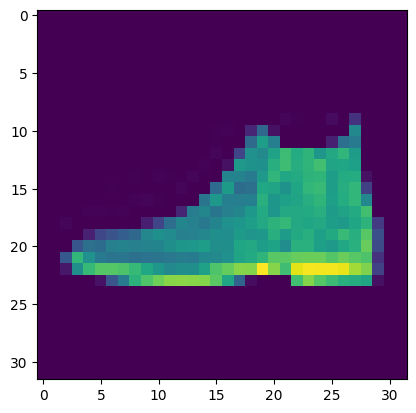

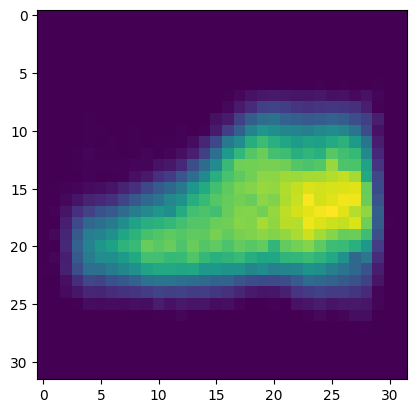

In [65]:
# 샘플링해서 디코딩해보기

exam_imgs = x_test[:5000]
exam_labs = y_test[:5000]

z_mean, z_log_var, reconstruction = vae.predict(exam_imgs)

# origin img
plt.imshow(exam_imgs[0])
plt.show()

# 복원된 이미지
plt.imshow(reconstruction[0])
plt.show()

157/157 [==============================] - 1s 7ms/step
[0.3716706 1.0038583]


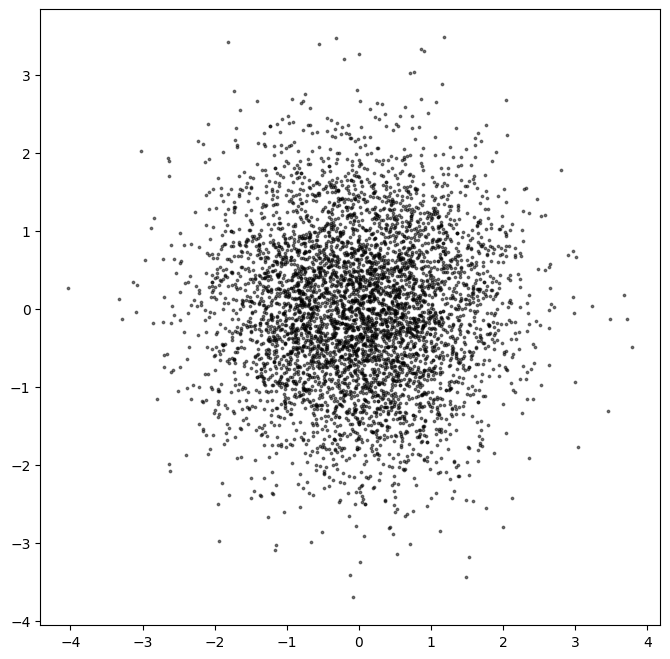

In [66]:
# 인코딩, 디코딩 과정 해보기

# 샘플 이미지로 임베딩 예측
z_mean, z_log_var, z = encoder.predict(exam_imgs)
# print(z_mean)
# print(z_log_var)
# z가 잠재공간에 인코딩된 포인트이다
print(z[0])

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()


1/1 [==============================] - 0s 56ms/step


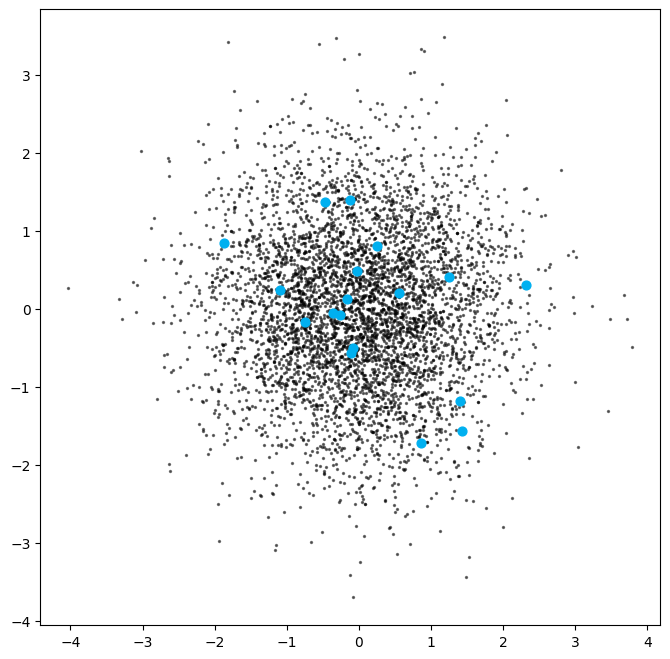

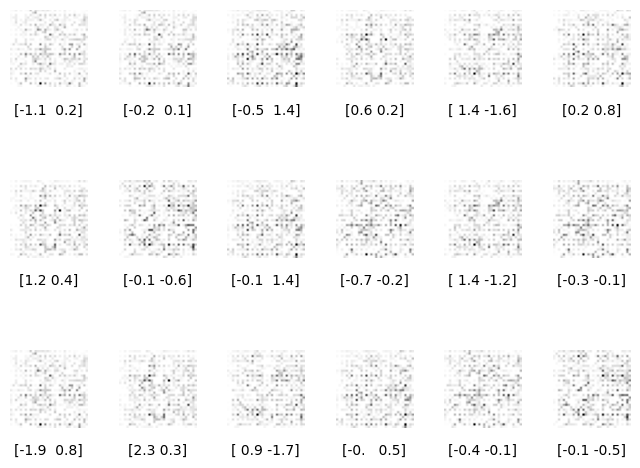

In [67]:
# 디코더를 이용한 새로운 이미지 생성
# 표준정규분포에서 18개 2차원으로 랜덤으로 샘플 만들기
z_sample = np.random.normal(size=(18, 2))
# print(z_sample[2])

reconstructions = decoder.predict(z_sample)
# print(reconstructions[0])

p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

# 임베딩공간의 포인트들을 p-값, 정규분포(-무한~무한)값을 0~1확률값으로 변환

plt.figure(figsize=(8, 8))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 옆에 생성 이미지와 임베딩 출력
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# 먼가 잘못됐다